In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import re
import string
from collections import Counter
from pathlib import Path

warnings.filterwarnings('ignore')
np.random.seed(42)

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})

nltk_resources = ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4']
for resource in nltk_resources:
    try:
        if resource == 'punkt_tab':
            nltk.data.find(f'tokenizers/{resource}/english/')
        elif resource in ['stopwords', 'wordnet', 'omw-1.4']:
            nltk.data.find(f'corpora/{resource}')
        else:
            nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource, quiet=True)

In [11]:
def to_lowercase(text):
    """Convierte texto a minúsculas."""
    return str(text).lower() if pd.notna(text) else ""

def remove_urls(text):
    """Elimina URLs del texto."""
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_mentions_hashtags(text):
    """Elimina menciones @ y hashtags #."""
    return re.sub(r'@\w+|#', '', text)

def remove_punctuation(text):
    """Elimina signos de puntuación."""
    return re.sub(r'[^a-zA-Z\s]', '', text)

def normalize_whitespace(text):
    """Normaliza espacios en blanco."""
    return ' '.join(text.split())

def get_english_stopwords():
    """Retorna stopwords en inglés."""
    return set(nltk.corpus.stopwords.words('english'))

def remove_stopwords(text, stopwords):
    """Elimina stopwords del texto."""
    words = text.split()
    return ' '.join([word for word in words if word not in stopwords])

def correct_spelling(text):
    """Corrige ortografía con TextBlob."""
    try:
        return str(TextBlob(text).correct())
    except:
        return text

def count_words(texts):
    """Cuenta frecuencia de palabras en lista de textos."""
    all_words = ' '.join(texts).split()
    return Counter(all_words)

def filter_by_min_frequency(word_counts, min_freq):
    """Filtra palabras por frecuencia mínima."""
    return {word: count for word, count in word_counts.items() if count >= min_freq}

def filter_by_max_frequency(word_counts, max_freq):
    """Filtra palabras por frecuencia máxima."""
    return {word: count for word, count in word_counts.items() if count <= max_freq}

def get_valid_words(word_counts, min_freq, max_freq):
    """Obtiene palabras válidas por rango de frecuencia."""
    return {
        word for word, count in word_counts.items()
        if min_freq <= count <= max_freq
    }

def filter_text_by_vocabulary(text, valid_words):
    """Filtra texto manteniendo solo palabras válidas."""
    words = [word for word in text.split() if word in valid_words]
    return ' '.join(words)

def tokenize_text(text):
    """Tokeniza texto individual."""
    return nltk.word_tokenize(text)

def stem_tokens(tokens):
    """Aplica stemming a lista de tokens."""
    stemmer = nltk.PorterStemmer()
    return [stemmer.stem(token) for token in tokens]

def lemmatize_tokens(tokens):
    """Aplica lemmatización a lista de tokens."""
    lemmatizer = nltk.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def tokens_to_text(tokens):
    """Convierte lista de tokens a texto."""
    return ' '.join(tokens)

def calculate_tf(text):
    """Calcula Term Frequency para un texto."""
    words = text.split()
    word_count = len(words)
    if word_count == 0:
        return {}
    
    tf_dict = {}
    for word in words:
        tf_dict[word] = tf_dict.get(word, 0) + 1
    
    for word in tf_dict:
        tf_dict[word] = tf_dict[word] / word_count
    
    return tf_dict

def calculate_idf(texts):
    """Calcula Inverse Document Frequency para colección de textos."""
    N = len(texts)
    idf_dict = {}
    all_words = set(word for text in texts for word in text.split())
    
    for word in all_words:
        containing_docs = sum(1 for text in texts if word in text.split())
        idf_dict[word] = np.log(N / containing_docs)
    
    return idf_dict

def calculate_tfidf(tf_dict, idf_dict):
    """Calcula TF-IDF dados diccionarios TF e IDF."""
    tfidf_dict = {}
    for word, tf_val in tf_dict.items():
        tfidf_dict[word] = tf_val * idf_dict.get(word, 0)
    return tfidf_dict

def get_sentiment_polarity(text):
    """Obtiene polaridad de sentimiento."""
    return TextBlob(text).sentiment.polarity

def get_sentiment_subjectivity(text):
    """Obtiene subjetividad de sentimiento."""
    return TextBlob(text).sentiment.subjectivity

def cosine_similarity_vectors(vec1, vec2):
    """Calcula similitud coseno entre dos vectores."""
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0, 0]

def plot_bar_chart(x_values, y_values, title, xlabel, ylabel, rotation=45):
    """Crea gráfico de barras básico."""
    fig, ax = plt.subplots(figsize=(12, 8))
    bars = ax.bar(range(len(x_values)), y_values, color='skyblue', alpha=0.8)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticks(range(len(x_values)))
    ax.set_xticklabels(x_values, rotation=rotation, ha='right')
    
    plt.tight_layout()
    plt.show()

def plot_log_log(x_values, y_values, title, xlabel, ylabel):
    """Crea gráfico log-log."""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(x_values, y_values, 'ro-', alpha=0.7)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def save_to_csv(data, filename):
    """Guarda datos a archivo CSV."""
    filepath = Path(filename)
    if isinstance(data, pd.DataFrame):
        data.to_csv(filepath, index=False)
    else:
        pd.Series(data).to_csv(filepath)
    return filepath

In [ ]:
# Cargar los datasets de entrenamiento y prueba
train_path = "/Users/pamelabenavides/repos/FCD_UV_2025/twitter_disaster_nlp/data/train.csv"
test_path = "/Users/pamelabenavides/repos/FCD_UV_2025/twitter_disaster_nlp/data/test.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

df_train.head()

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# Análisis inicial del dataset
target_counts = df_train['target'].value_counts()
missing_counts = df_train.isnull().sum()

print(f"Dataset shape: {df_train.shape}")
print(f"Target distribution: {dict(target_counts)}")
print(f"Missing values: {dict(missing_counts[missing_counts > 0])}")

Dataset shape: (7613, 5)
Target distribution: {0: np.int64(4342), 1: np.int64(3271)}
Missing values: {'keyword': np.int64(61), 'location': np.int64(2533)}


In [ ]:
# Análisis de tweets
all_texts = df_train['text'].tolist()
disaster_tweets = df_train[df_train['target'] == 1]['text']
non_disaster_tweets = df_train[df_train['target'] == 0]['text']

print("\nDisaster tweet samples:")
for i, tweet in enumerate(disaster_tweets.head(3), 1):
    print(f"{i}. {tweet[:100]}...")

print("\nNon-disaster tweet samples:")
for i, tweet in enumerate(non_disaster_tweets.head(3), 1):
    print(f"{i}. {tweet[:100]}...")


Disaster tweet samples:
1. Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all...
2. Forest fire near La Ronge Sask. Canada...
3. All residents asked to 'shelter in place' are being notified by officers. No other evacuation or she...

Non-disaster tweet samples:
1. What's up man?...
2. I love fruits...
3. Summer is lovely...


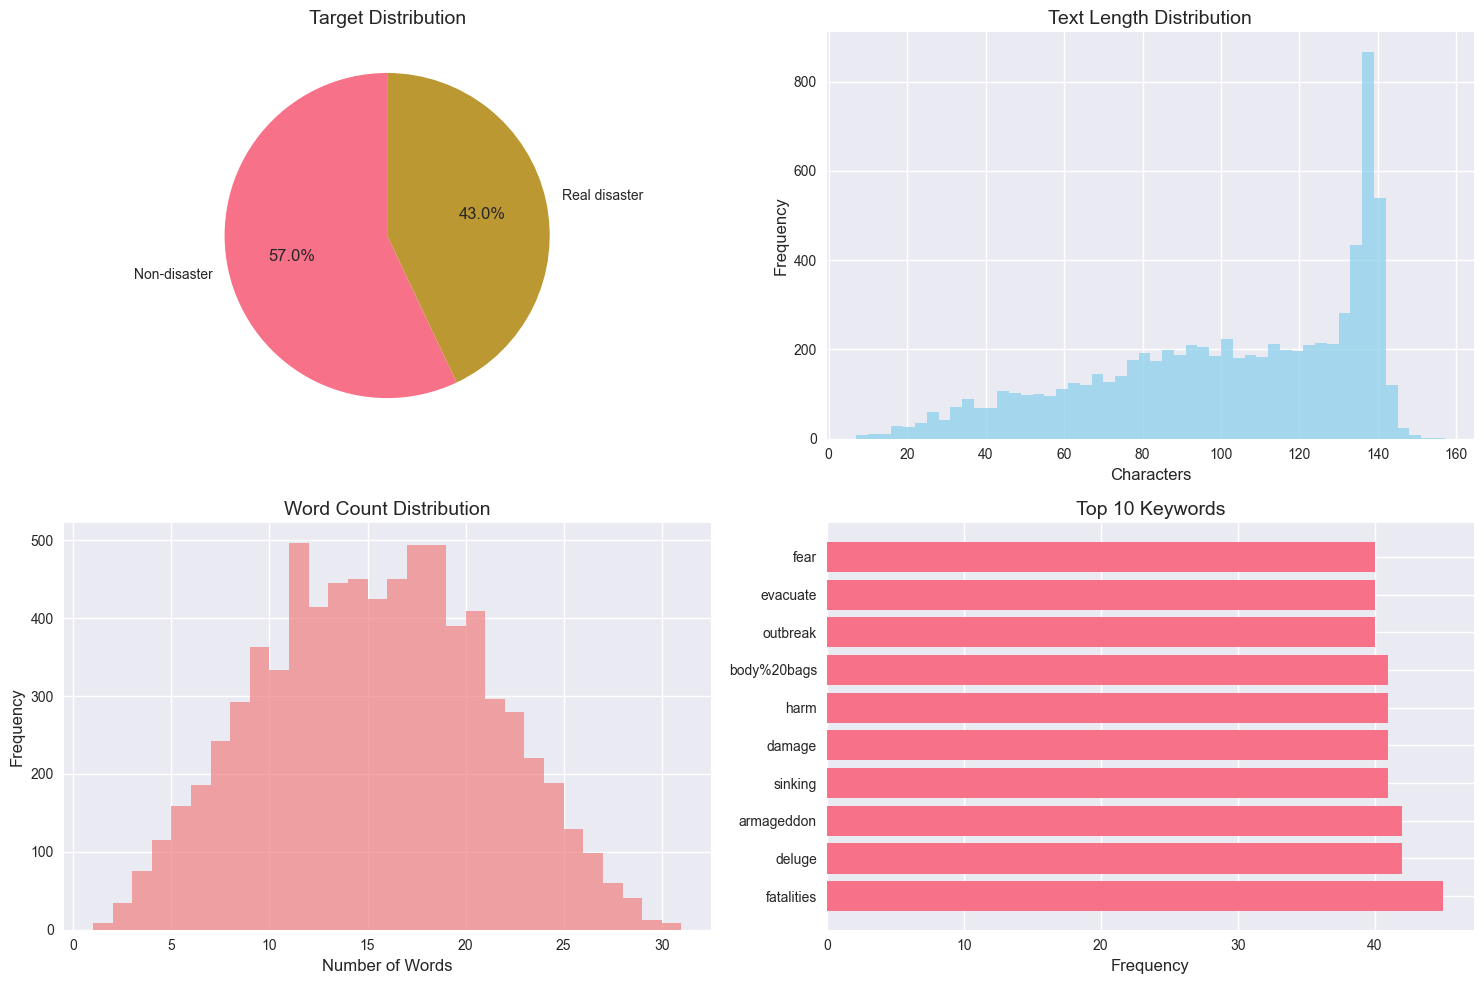

In [ ]:
# Visualización de estadísticas descriptivas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].pie(target_counts.values, labels=['Non-disaster', 'Real disaster'], 
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Target Distribution')

text_lengths = df_train['text'].str.len()
axes[0, 1].hist(text_lengths, bins=50, alpha=0.7, color='skyblue')
axes[0, 1].set_title('Text Length Distribution')
axes[0, 1].set_xlabel('Characters')
axes[0, 1].set_ylabel('Frequency')

word_counts = df_train['text'].str.split().str.len()
axes[1, 0].hist(word_counts, bins=30, alpha=0.7, color='lightcoral')
axes[1, 0].set_title('Word Count Distribution')
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].set_ylabel('Frequency')

keyword_counts = df_train['keyword'].value_counts().head(10)
axes[1, 1].barh(range(len(keyword_counts)), keyword_counts.values)
axes[1, 1].set_yticks(range(len(keyword_counts)))
axes[1, 1].set_yticklabels(keyword_counts.index)
axes[1, 1].set_title('Top 10 Keywords')
axes[1, 1].set_xlabel('Frequency')

plt.tight_layout()
plt.show()

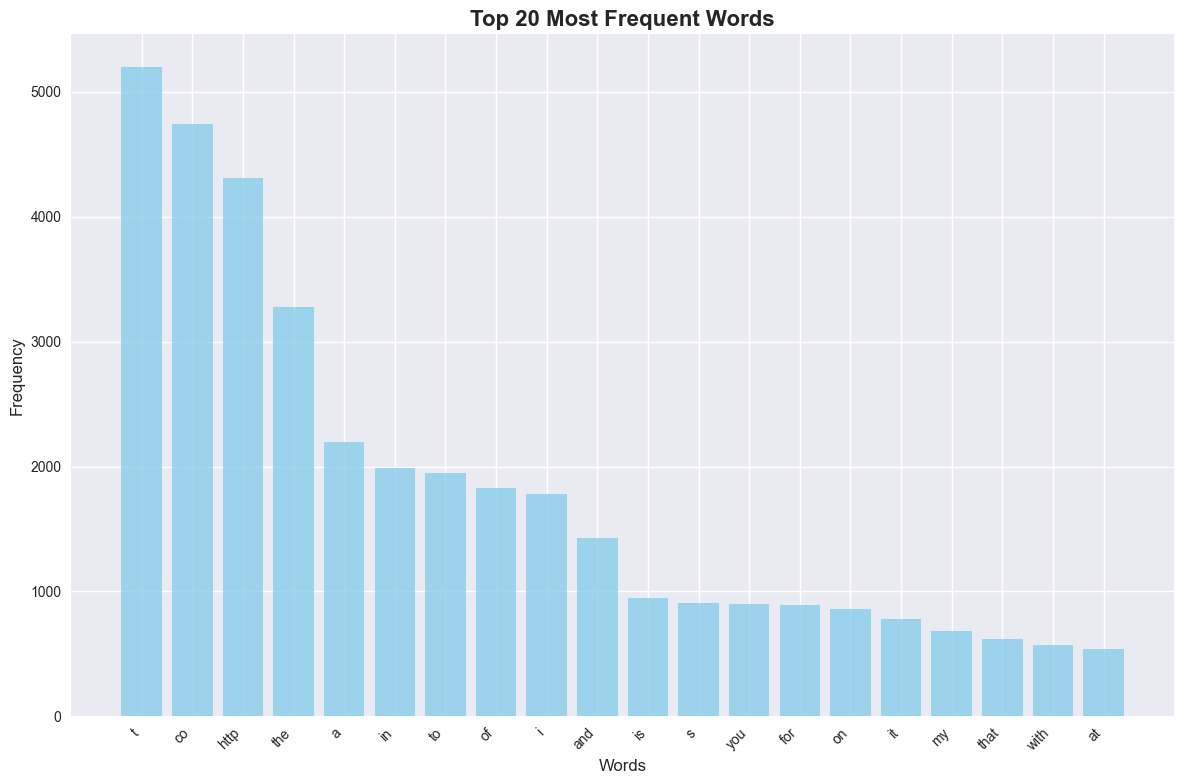

In [ ]:

# Procesamiento de texto
vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
word_matrix = vectorizer.fit_transform(all_texts)

feature_names = vectorizer.get_feature_names_out()
word_frequencies = word_matrix.sum(axis=0).A1
word_freq_dict = dict(zip(feature_names, word_frequencies))

sorted_words = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

top_20_words = sorted_words[:20]
words, frequencies = zip(*top_20_words)

# Visualización de las 20 palabras más frecuentes
plot_bar_chart(
    x_values=words,
    y_values=frequencies,
    title="Top 20 Most Frequent Words",
    xlabel="Words",
    ylabel="Frequency",
    rotation=45
)

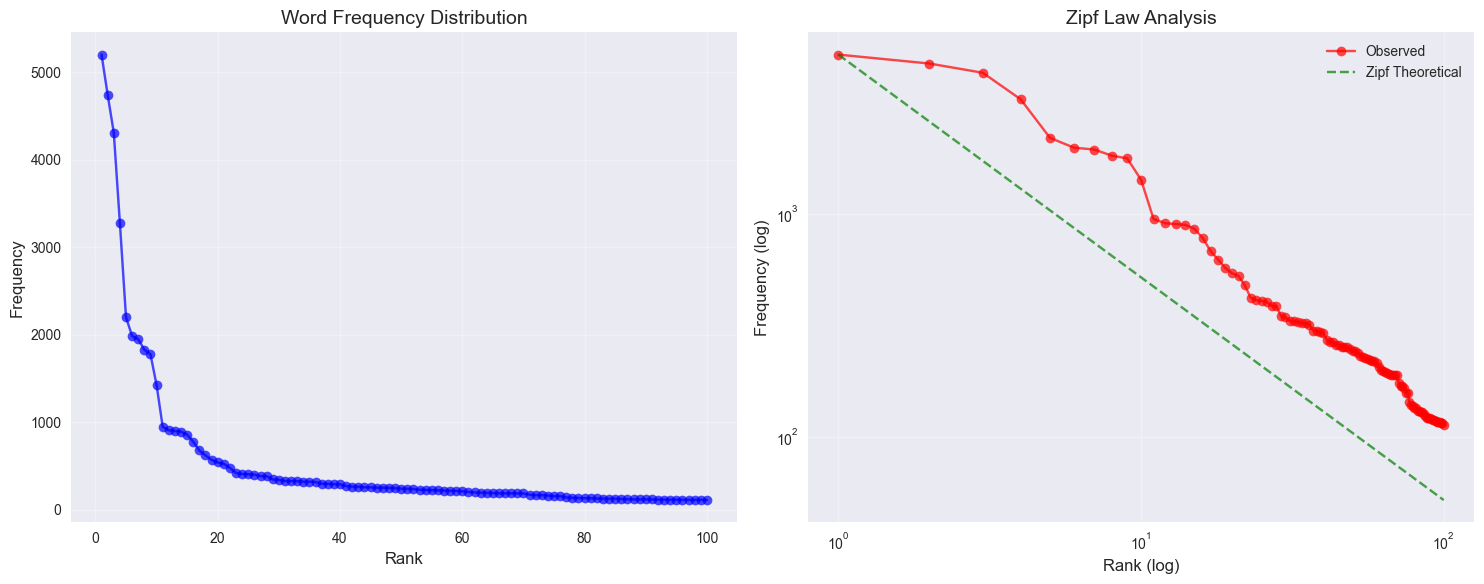

Zipf Law Analysis:
Most frequent word: 't' (5199 occurrences)
1st/2nd word ratio: 1.10 (Zipf predicts ~2.0)
2nd/4th word ratio: 1.45 (Zipf predicts ~2.0)


In [32]:
# Análisis de Zipf Law
ranks = np.arange(1, 101)
top_100_frequencies = [freq for _, freq in sorted_words[:100]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(ranks, top_100_frequencies, 'bo-', alpha=0.7)
ax1.set_xlabel('Rank')
ax1.set_ylabel('Frequency')
ax1.set_title('Word Frequency Distribution')
ax1.grid(True, alpha=0.3)

ax2.loglog(ranks, top_100_frequencies, 'ro-', alpha=0.7, label='Observed')
zipf_theoretical = top_100_frequencies[0] / ranks
ax2.loglog(ranks, zipf_theoretical, 'g--', alpha=0.7, label='Zipf Theoretical')
ax2.set_xlabel('Rank (log)')
ax2.set_ylabel('Frequency (log)')
ax2.set_title('Zipf Law Analysis')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

first_word_freq = top_100_frequencies[0]
second_word_freq = top_100_frequencies[1]
fourth_word_freq = top_100_frequencies[3]

zipf_ratio_1_2 = first_word_freq / second_word_freq
zipf_ratio_2_4 = second_word_freq / fourth_word_freq

print(f"Zipf Law Analysis:")
print(f"Most frequent word: '{sorted_words[0][0]}' ({first_word_freq} occurrences)")
print(f"1st/2nd word ratio: {zipf_ratio_1_2:.2f} (Zipf predicts ~2.0)")
print(f"2nd/4th word ratio: {zipf_ratio_2_4:.2f} (Zipf predicts ~2.0)")

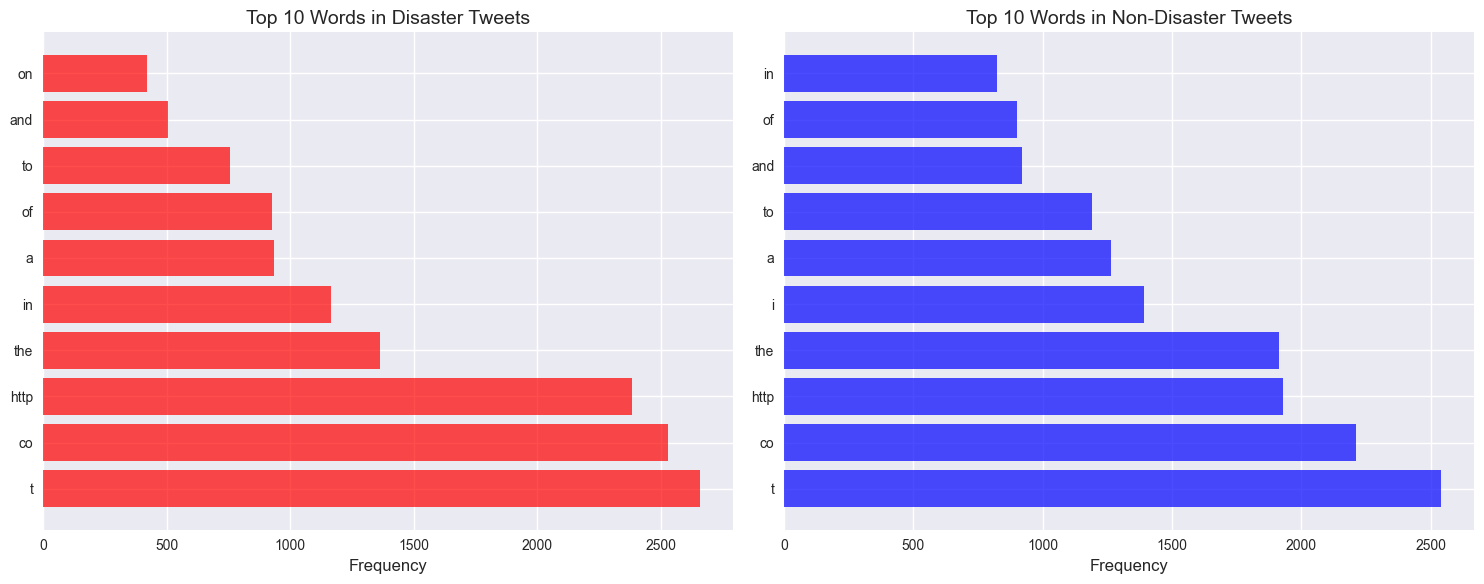


Vocabulary size: 16,160 unique words
Total word occurrences: 121,078
Average words per tweet: 15.9

Disaster tweets vocabulary: 8,668 unique words
Non-disaster tweets vocabulary: 11,461 unique words


In [33]:
# Análisis de vocabulario
disaster_vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
disaster_matrix = disaster_vectorizer.fit_transform(disaster_tweets)
disaster_word_freq = dict(zip(
    disaster_vectorizer.get_feature_names_out(),
    disaster_matrix.sum(axis=0).A1
))

non_disaster_vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
non_disaster_matrix = non_disaster_vectorizer.fit_transform(non_disaster_tweets)
non_disaster_word_freq = dict(zip(
    non_disaster_vectorizer.get_feature_names_out(),
    non_disaster_matrix.sum(axis=0).A1
))

disaster_top_10 = sorted(disaster_word_freq.items(), key=lambda x: x[1], reverse=True)[:10]
non_disaster_top_10 = sorted(non_disaster_word_freq.items(), key=lambda x: x[1], reverse=True)[:10]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

disaster_words, disaster_freqs = zip(*disaster_top_10)
ax1.barh(range(len(disaster_words)), disaster_freqs, color='red', alpha=0.7)
ax1.set_yticks(range(len(disaster_words)))
ax1.set_yticklabels(disaster_words)
ax1.set_title('Top 10 Words in Disaster Tweets')
ax1.set_xlabel('Frequency')

non_disaster_words, non_disaster_freqs = zip(*non_disaster_top_10)
ax2.barh(range(len(non_disaster_words)), non_disaster_freqs, color='blue', alpha=0.7)
ax2.set_yticks(range(len(non_disaster_words)))
ax2.set_yticklabels(non_disaster_words)
ax2.set_title('Top 10 Words in Non-Disaster Tweets')
ax2.set_xlabel('Frequency')

plt.tight_layout()
plt.show()

print(f"\nVocabulary size: {len(feature_names):,} unique words")
print(f"Total word occurrences: {word_frequencies.sum():,}")
print(f"Average words per tweet: {word_frequencies.sum() / len(all_texts):.1f}")

print(f"\nDisaster tweets vocabulary: {len(disaster_word_freq):,} unique words")
print(f"Non-disaster tweets vocabulary: {len(non_disaster_word_freq):,} unique words")

English stopwords count: 198
Sample stopwords: ['any', 'during', 'more', 'because', 'about', 'doing', 'nor', 'through', 'yours', 'o', 'that', 'an', "aren't", 'while', 'both']

Top 10 stopwords in our dataset:
'the': 3270 occurrences
'a': 2197 occurrences
'in': 1979 occurrences
'to': 1946 occurrences
'of': 1828 occurrences
'and': 1420 occurrences
'i': 1404 occurrences
'is': 944 occurrences
'for': 893 occurrences
'on': 855 occurrences

Frequency analysis after stopword removal:
Total unique words: 14,573
Very rare words (< 2 occurrences): 8,395
Very frequent words (> 761 occurrences): 0
Words to keep: 6,178

Sample tweets after preprocessing:
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all...
Processed: deeds reason earthquake may allah forgive us...

Original: Forest fire near La Ronge Sask. Canada...
Processed: forest fire near la canada...

Original: All residents asked to 'shelter in place' are being notified by officers. No oth...
Processed: residents

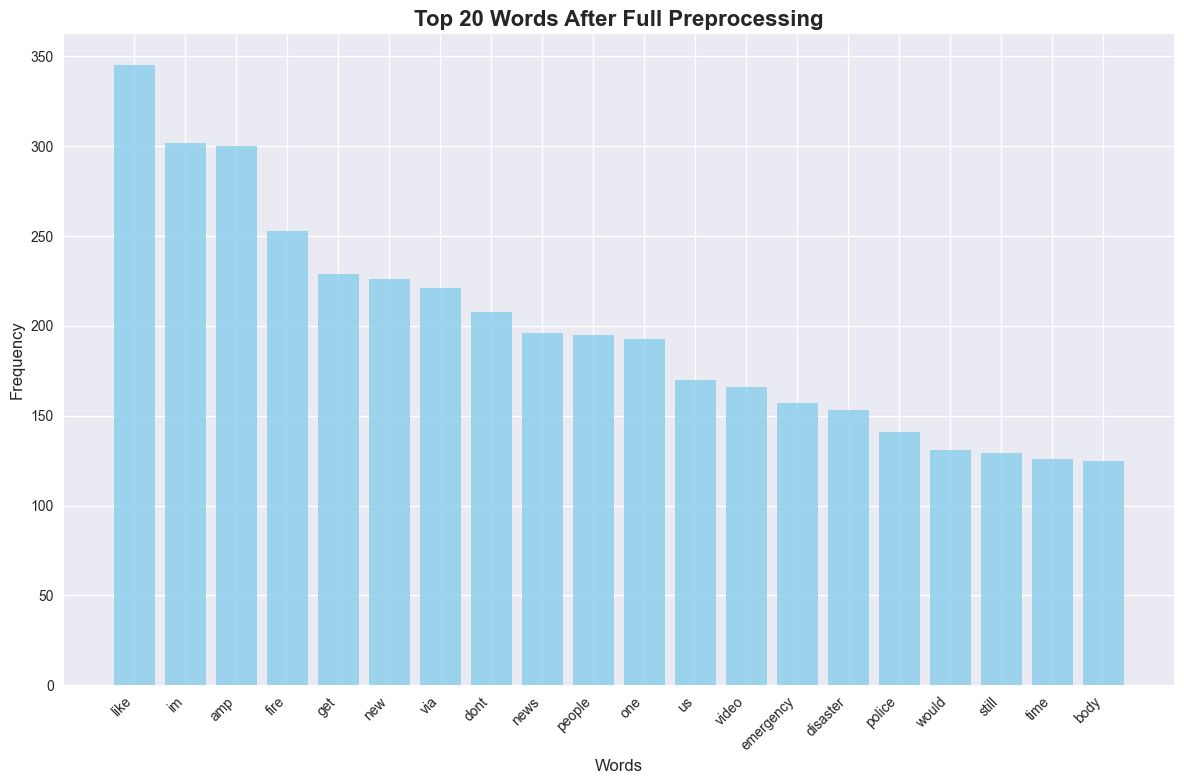


Final preprocessing results:
Vocabulary size: 6,210 unique words
Total word occurrences: 58,318
Average words per tweet: 7.7

Comparison with raw data:
Before preprocessing: 16,160 unique words
After preprocessing:  6,210 unique words
Vocabulary reduction: 61.6%


In [ ]:
# Preprocesamiento de texto
def preprocess_tweet(text):
    """Pipeline completo de preprocesamiento para un tweet."""
    text = to_lowercase(text)
    text = remove_urls(text)
    text = remove_mentions_hashtags(text)
    text = remove_punctuation(text)
    text = normalize_whitespace(text)
    return text

all_texts_clean = [preprocess_tweet(text) for text in df_train['text']]

stopwords = get_english_stopwords()

print(f"English stopwords count: {len(stopwords)}")
print(f"Sample stopwords: {list(stopwords)[:15]}")

stopword_counter = Counter()
for text in all_texts_clean:
    words = text.split()
    for word in words:
        if word in stopwords:
            stopword_counter[word] += 1

top_stopwords = stopword_counter.most_common(10)
print(f"\nTop 10 stopwords in our dataset:")
for word, count in top_stopwords:
    print(f"'{word}': {count} occurrences")

texts_no_stopwords = [remove_stopwords(text, stopwords) for text in all_texts_clean]

vectorizer_clean = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
word_matrix_clean = vectorizer_clean.fit_transform(texts_no_stopwords)

feature_names_clean = vectorizer_clean.get_feature_names_out()
word_frequencies_clean = word_matrix_clean.sum(axis=0).A1
word_freq_dict_clean = dict(zip(feature_names_clean, word_frequencies_clean))

sorted_words_clean = sorted(word_freq_dict_clean.items(), key=lambda x: x[1], reverse=True)

total_words = len(feature_names_clean)
min_freq_threshold = 2
max_freq_threshold = int(0.1 * len(texts_no_stopwords))  # Aparece en más del 10% de documentos

very_rare_words = sum(1 for _, freq in word_freq_dict_clean.items() if freq < min_freq_threshold)
very_frequent_words = sum(1 for _, freq in word_freq_dict_clean.items() if freq > max_freq_threshold)

print(f"\nFrequency analysis after stopword removal:")
print(f"Total unique words: {total_words:,}")
print(f"Very rare words (< {min_freq_threshold} occurrences): {very_rare_words:,}")
print(f"Very frequent words (> {max_freq_threshold} occurrences): {very_frequent_words:,}")
print(f"Words to keep: {total_words - very_rare_words - very_frequent_words:,}")

valid_words = {
    word for word, freq in word_freq_dict_clean.items()
    if min_freq_threshold <= freq <= max_freq_threshold
}

texts_filtered = []
for text in texts_no_stopwords:
    words = [word for word in text.split() if word in valid_words]
    texts_filtered.append(' '.join(words))

print(f"\nSample tweets after preprocessing:")
for i in range(3):
    print(f"Original: {df_train['text'].iloc[i][:80]}...")
    print(f"Processed: {texts_filtered[i][:80]}...")
    print()

sample_texts_for_spelling = texts_filtered[:100]  # Solo 100 para demo
texts_spell_corrected = []

print("Applying spelling correction to sample (first 100 tweets)...")
for i, text in enumerate(sample_texts_for_spelling):
    if i % 20 == 0:
        print(f"Processing tweet {i}/100...")
    corrected = correct_spelling(text)
    texts_spell_corrected.append(corrected)


final_processed_texts = texts_filtered.copy()
final_processed_texts[:100] = texts_spell_corrected

vectorizer_final = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
word_matrix_final = vectorizer_final.fit_transform(final_processed_texts)

feature_names_final = vectorizer_final.get_feature_names_out()
word_frequencies_final = word_matrix_final.sum(axis=0).A1
word_freq_dict_final = dict(zip(feature_names_final, word_frequencies_final))

sorted_words_final = sorted(word_freq_dict_final.items(), key=lambda x: x[1], reverse=True)
top_20_final = sorted_words_final[:20]

words_final, frequencies_final = zip(*top_20_final)

plot_bar_chart(
    x_values=words_final,
    y_values=frequencies_final,
    title="Top 20 Words After Full Preprocessing",
    xlabel="Words",
    ylabel="Frequency",
    rotation=45
)

print(f"\nFinal preprocessing results:")
print(f"Vocabulary size: {len(feature_names_final):,} unique words")
print(f"Total word occurrences: {word_frequencies_final.sum():,}")
print(f"Average words per tweet: {word_frequencies_final.sum() / len(final_processed_texts):.1f}")

print(f"\nComparison with raw data:")
print(f"Before preprocessing: {len(feature_names):,} unique words")
print(f"After preprocessing:  {len(feature_names_final):,} unique words")
print(f"Vocabulary reduction: {(1 - len(feature_names_final)/len(feature_names))*100:.1f}%")

Antes: 16,160 palabras → Después: 6,210  palabras
61.6% de reducción manteniendo palabras relevantes
Promedio de palabras por tweet: 15.9 → 7.7 


In [34]:
# Ejemlpo Tokenization
sample_tweets = final_processed_texts[:10]

print("TOKENIZATION EXAMPLES:")
print("=" * 50)
tokenized_samples = []
for i, text in enumerate(sample_tweets):
    tokens = tokenize_text(text)
    tokenized_samples.append(tokens)
    print(f"Tweet {i+1}:")
    print(f"Original: {text}")
    print(f"Tokens:   {tokens}")
    print()

TOKENIZATION EXAMPLES:
Tweet 1:
Original: deeds reason earthquake may allah forgive us
Tokens:   ['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']

Tweet 2:
Original: forest fire near la canada
Tokens:   ['forest', 'fire', 'near', 'la', 'canada']

Tweet 3:
Original: residents asked shelter place officers evacuation shelter place orders expected
Tokens:   ['residents', 'asked', 'shelter', 'place', 'officers', 'evacuation', 'shelter', 'place', 'orders', 'expected']

Tweet 4:
Original: people receive wildfires evacuation orders california
Tokens:   ['people', 'receive', 'wildfires', 'evacuation', 'orders', 'california']

Tweet 5:
Original: got sent photo alaska smoke wildfires school
Tokens:   ['got', 'sent', 'photo', 'alaska', 'smoke', 'wildfires', 'school']

Tweet 6:
Original: rockyfire update california why closed due lake county fire fire wildfires
Tokens:   ['rockyfire', 'update', 'california', 'why', 'closed', 'due', 'lake', 'county', 'fire', 'fire', 'wildfires']

T

In [35]:
# Stemming vs Lemmatization
stemmer = nltk.PorterStemmer()
lemmatizer = nltk.WordNetLemmatizer()

print("STEMMING vs LEMMATIZATION COMPARISON:")
print("=" * 50)

test_words = ['running', 'ran', 'runs', 'easily', 'fairly', 'better', 'worse', 'studies', 'studying', 'flies', 
              'damaged', 'damages', 'damaging', 'evacuated', 'evacuating', 'evacuation', 'flooded', 'flooding', 'fires']

print(f"{'Word':<15} {'Stemmed':<15} {'Lemmatized':<15}")
print("-" * 45)
for word in test_words:
    stemmed = stemmer.stem(word)
    lemmatized = lemmatizer.lemmatize(word)
    print(f"{word:<15} {stemmed:<15} {lemmatized:<15}")

print(f"\nPROCESSING SAMPLE TWEETS:")
print("=" * 50)

def process_with_stemming(texts):
    """Aplica stemming a lista de textos."""
    stemmed_texts = []
    for text in texts:
        tokens = tokenize_text(text)
        stemmed_tokens = stem_tokens(tokens)
        stemmed_text = tokens_to_text(stemmed_tokens)
        stemmed_texts.append(stemmed_text)
    return stemmed_texts

def process_with_lemmatization(texts):
    """Aplica lemmatización a lista de textos."""
    lemmatized_texts = []
    for text in texts:
        tokens = tokenize_text(text)
        lemmatized_tokens = lemmatize_tokens(tokens)
        lemmatized_text = tokens_to_text(lemmatized_tokens)
        lemmatized_texts.append(lemmatized_text)
    return lemmatized_texts

sample_for_comparison = final_processed_texts[:5]
stemmed_samples = process_with_stemming(sample_for_comparison)
lemmatized_samples = process_with_lemmatization(sample_for_comparison)

for i in range(5):
    print(f"Tweet {i+1}:")
    print(f"Original:    {sample_for_comparison[i]}")
    print(f"Stemmed:     {stemmed_samples[i]}")
    print(f"Lemmatized:  {lemmatized_samples[i]}")
    print()

STEMMING vs LEMMATIZATION COMPARISON:
Word            Stemmed         Lemmatized     
---------------------------------------------
running         run             running        
ran             ran             ran            
runs            run             run            
easily          easili          easily         
fairly          fairli          fairly         
better          better          better         
worse           wors            worse          
studies         studi           study          
studying        studi           studying       
flies           fli             fly            
damaged         damag           damaged        
damages         damag           damage         
damaging        damag           damaging       
evacuated       evacu           evacuated      
evacuating      evacu           evacuating     
evacuation      evacu           evacuation     
flooded         flood           flooded        
flooding        flood           flooding       
fire

In [ ]:
# Procesamiento completo del dataset
stemmed_texts = process_with_stemming(final_processed_texts)
lemmatized_texts = process_with_lemmatization(final_processed_texts)

def get_vocabulary_stats(texts, method_name):
    """Obtiene estadísticas de vocabulario para un conjunto de textos."""
    vectorizer = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
    matrix = vectorizer.fit_transform(texts)
    vocab_size = len(vectorizer.get_feature_names_out())
    total_words = matrix.sum()
    return vocab_size, total_words, method_name

original_stats = get_vocabulary_stats(final_processed_texts, "Original")
stemmed_stats = get_vocabulary_stats(stemmed_texts, "Stemmed")
lemmatized_stats = get_vocabulary_stats(lemmatized_texts, "Lemmatized")

print("VOCABULARY COMPARISON:")
print("=" * 55)
print(f"{'Method':<12} {'Vocab Size':<12} {'Total Words':<12} {'Avg/Tweet':<12}")
print("-" * 55)

for vocab_size, total_words, method in [original_stats, stemmed_stats, lemmatized_stats]:
    avg_words = total_words / len(final_processed_texts)
    print(f"{method:<12} {vocab_size:<12,} {total_words:<12,} {avg_words:<12.1f}")

reduction_stemmed = (1 - stemmed_stats[0] / original_stats[0]) * 100
reduction_lemmatized = (1 - lemmatized_stats[0] / original_stats[0]) * 100

print(f"\nVOCABULARY REDUCTION:")
print(f"Stemming: {reduction_stemmed:.1f}% vocabulary reduction")
print(f"Lemmatization: {reduction_lemmatized:.1f}% vocabulary reduction")

VOCABULARY COMPARISON:
Method       Vocab Size   Total Words  Avg/Tweet   
-------------------------------------------------------
Original     6,210        58,318       7.7         
Stemmed      4,811        58,416       7.7         
Lemmatized   5,546        58,416       7.7         

VOCABULARY REDUCTION:
Stemming: 22.5% vocabulary reduction
Lemmatization: 10.7% vocabulary reduction


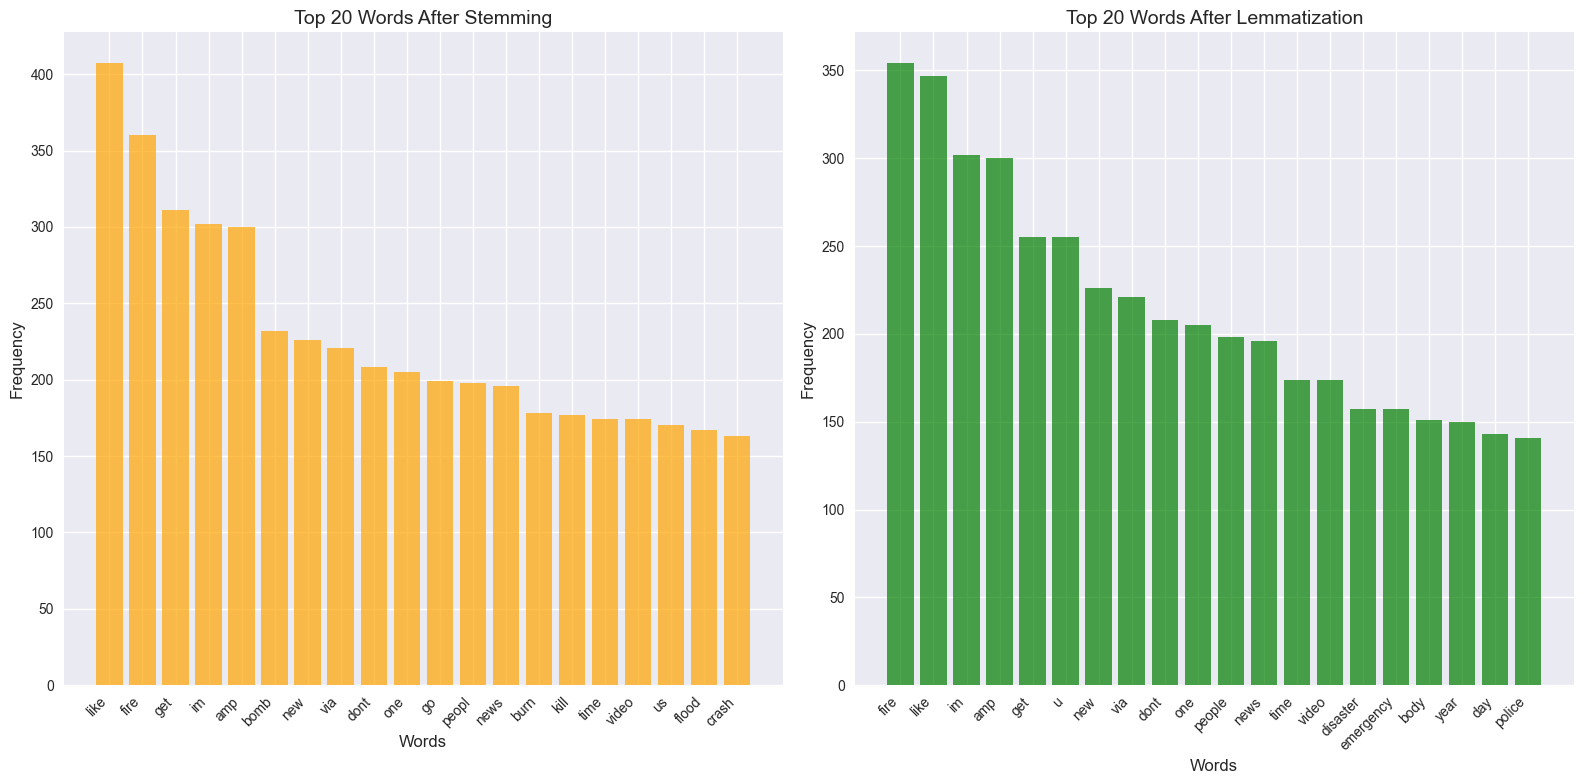

In [ ]:
# Visualización de las palabras más frecuentes después de stemming y lemmatization
vectorizer_stemmed = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
matrix_stemmed = vectorizer_stemmed.fit_transform(stemmed_texts)
word_freq_stemmed = dict(zip(
    vectorizer_stemmed.get_feature_names_out(),
    matrix_stemmed.sum(axis=0).A1
))

vectorizer_lemmatized = CountVectorizer(lowercase=True, token_pattern=r'\b[a-zA-Z]+\b')
matrix_lemmatized = vectorizer_lemmatized.fit_transform(lemmatized_texts)
word_freq_lemmatized = dict(zip(
    vectorizer_lemmatized.get_feature_names_out(),
    matrix_lemmatized.sum(axis=0).A1
))

top_20_stemmed = sorted(word_freq_stemmed.items(), key=lambda x: x[1], reverse=True)[:20]
top_20_lemmatized = sorted(word_freq_lemmatized.items(), key=lambda x: x[1], reverse=True)[:20]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

words_stemmed, freqs_stemmed = zip(*top_20_stemmed)
ax1.bar(range(len(words_stemmed)), freqs_stemmed, color='orange', alpha=0.7)
ax1.set_title('Top 20 Words After Stemming')
ax1.set_xlabel('Words')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(len(words_stemmed)))
ax1.set_xticklabels(words_stemmed, rotation=45, ha='right')

words_lemmatized, freqs_lemmatized = zip(*top_20_lemmatized)
ax2.bar(range(len(words_lemmatized)), freqs_lemmatized, color='green', alpha=0.7)
ax2.set_title('Top 20 Words After Lemmatization')
ax2.set_xlabel('Words')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(len(words_lemmatized)))
ax2.set_xticklabels(words_lemmatized, rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [36]:
# Análisis comparación de metodos
common_stemmed_words = set(word for word, _ in top_20_stemmed)
common_lemmatized_words = set(word for word, _ in top_20_lemmatized)
overlap = common_stemmed_words.intersection(common_lemmatized_words)

print("TOP 20 WORDS ANALYSIS:")
print("=" * 30)
print(f"Words overlap: {len(overlap)}/20")
print(f"Overlapping words: {sorted(list(overlap))}")

print(f"\nStemming unique words: {sorted(list(common_stemmed_words - overlap))}")
print(f"Lemmatization unique words: {sorted(list(common_lemmatized_words - overlap))}")

print("\nMETHOD COMPARISON:")
print("=" * 30)
print("STEMMING:")
print("+ Greater vocabulary reduction")
print("+ Faster processing")
print("- Creates non-words ('evacu', 'wildfir')")
print("- May lose semantic meaning")

print("\nLEMMATIZATION:")
print("+ Preserves real words")
print("+ Better semantic preservation")  
print("+ More suitable for analysis")
print("- Less vocabulary reduction")

chosen_method = "lemmatized"
chosen_texts = lemmatized_texts

print(f"\nRECOMMENDATION: Using LEMMATIZATION")
print("Reason: Better semantic preservation for sentiment analysis and TF-IDF")

print(f"\nFinal processed dataset ready:")
print(f"Method: {chosen_method}")
print(f"Total tweets: {len(chosen_texts):,}")
print(f"Vocabulary size: {lemmatized_stats[0]:,}")
print(f"Average words per tweet: {lemmatized_stats[1] / len(chosen_texts):.1f}")

TOP 20 WORDS ANALYSIS:
Words overlap: 12/20
Overlapping words: ['amp', 'dont', 'fire', 'get', 'im', 'like', 'new', 'news', 'one', 'time', 'via', 'video']

Stemming unique words: ['bomb', 'burn', 'crash', 'flood', 'go', 'kill', 'peopl', 'us']
Lemmatization unique words: ['body', 'day', 'disaster', 'emergency', 'people', 'police', 'u', 'year']

METHOD COMPARISON:
STEMMING:
+ Greater vocabulary reduction
+ Faster processing
- Creates non-words ('evacu', 'wildfir')
- May lose semantic meaning

LEMMATIZATION:
+ Preserves real words
+ Better semantic preservation
+ More suitable for analysis
- Less vocabulary reduction

RECOMMENDATION: Using LEMMATIZATION
Reason: Better semantic preservation for sentiment analysis and TF-IDF

Final processed dataset ready:
Method: lemmatized
Total tweets: 7,613
Vocabulary size: 5,546
Average words per tweet: 7.7


In [28]:
# IMPLEMENTACIÓN MANUAL DE TF-IDF

def calculate_manual_tfidf(texts):
    """Calcula TF-IDF manualmente para comprensión conceptual."""
    
    print("Calculating TF-IDF manually...")
    
    all_words = set()
    for text in texts:
        words = text.split()
        all_words.update(words)
    
    vocabulary = sorted(list(all_words))
    vocab_size = len(vocabulary)
    word_to_index = {word: i for i, word in enumerate(vocabulary)}
    
    print(f"Vocabulary size: {vocab_size:,} unique words")
    
    idf_dict = calculate_idf(texts)
    
    tfidf_matrix = np.zeros((len(texts), vocab_size))
    
    for doc_idx, text in enumerate(texts):
        if doc_idx % 1000 == 0:
            print(f"Processing document {doc_idx}/{len(texts)}")
            
        tf_dict = calculate_tf(text)
        
        for word, tf_value in tf_dict.items():
            if word in word_to_index:
                word_idx = word_to_index[word]
                idf_value = idf_dict.get(word, 0)
                tfidf_value = tf_value * idf_value
                tfidf_matrix[doc_idx, word_idx] = tfidf_value
    
    return tfidf_matrix, vocabulary, word_to_index

sample_texts = chosen_texts[:100]  # Solo 100 para demo rápida

manual_tfidf_matrix, manual_vocabulary, manual_word_to_index = calculate_manual_tfidf(sample_texts)

print(f"\nManual TF-IDF Matrix Shape: {manual_tfidf_matrix.shape}")
print(f"Non-zero elements: {np.count_nonzero(manual_tfidf_matrix):,}")
print(f"Sparsity: {(1 - np.count_nonzero(manual_tfidf_matrix) / manual_tfidf_matrix.size) * 100:.1f}%")

doc_idx = 0
print(f"\nExample - Document {doc_idx}:")
print(f"Original text: {sample_texts[doc_idx]}")

doc_tfidf = manual_tfidf_matrix[doc_idx]
non_zero_indices = np.where(doc_tfidf > 0)[0]

print(f"TF-IDF values (top 10):")
word_scores = [(manual_vocabulary[i], doc_tfidf[i]) for i in non_zero_indices]
word_scores.sort(key=lambda x: x[1], reverse=True)

for word, score in word_scores[:10]:
    print(f"  {word}: {score:.4f}")

print(f"\nManual TF-IDF calculation completed for {len(sample_texts)} documents")

Calculating TF-IDF manually...
Vocabulary size: 375 unique words
Processing document 0/100

Manual TF-IDF Matrix Shape: (100, 375)
Non-zero elements: 598
Sparsity: 98.4%

Example - Document 0:
Original text: deed reason earthquake may allah forgive u
TF-IDF values (top 10):
  allah: 0.6579
  deed: 0.6579
  earthquake: 0.6579
  forgive: 0.6579
  may: 0.6579
  reason: 0.6579
  u: 0.4598

Manual TF-IDF calculation completed for 100 documents


In [37]:
# COMPARACIÓN CON SKLEARN TF-IDF

sklearn_vectorizer = TfidfVectorizer(
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]+\b',
    use_idf=True,
    smooth_idf=True,
    norm='l2'
)

sklearn_tfidf_matrix = sklearn_vectorizer.fit_transform(sample_texts)
sklearn_vocabulary = sklearn_vectorizer.get_feature_names_out()

print("SKLEARN TF-IDF vs MANUAL COMPARISON:")
print("=" * 50)
print(f"{'Metric':<25} {'Manual':<15} {'Sklearn':<15}")
print("-" * 55)
print(f"{'Matrix shape':<25} {str(manual_tfidf_matrix.shape):<15} {str(sklearn_tfidf_matrix.shape):<15}")
print(f"{'Vocabulary size':<25} {len(manual_vocabulary):<15} {len(sklearn_vocabulary):<15}")
print(f"{'Non-zero elements':<25} {np.count_nonzero(manual_tfidf_matrix):<15} {sklearn_tfidf_matrix.nnz:<15}")
print(f"{'Sparsity %':<25} {(1 - np.count_nonzero(manual_tfidf_matrix) / manual_tfidf_matrix.size) * 100:<15.1f} {(1 - sklearn_tfidf_matrix.nnz / sklearn_tfidf_matrix.size) * 100:<15.1f}")

doc_idx = 0
sklearn_doc_vector = sklearn_tfidf_matrix[doc_idx].toarray().flatten()
sklearn_non_zero = np.where(sklearn_doc_vector > 0)[0]

print(f"\nDOCUMENT {doc_idx} COMPARISON:")
print(f"Text: {sample_texts[doc_idx]}")
print(f"\n{'Word':<15} {'Manual TF-IDF':<15} {'Sklearn TF-IDF':<15}")
print("-" * 45)

manual_doc_vector = manual_tfidf_matrix[doc_idx]
words_in_doc = sample_texts[doc_idx].split()

for word in words_in_doc:
    if word in manual_word_to_index:
        manual_idx = manual_word_to_index[word]
        manual_score = manual_doc_vector[manual_idx]
        
        if word in sklearn_vocabulary:
            sklearn_idx = np.where(sklearn_vocabulary == word)[0][0]
            sklearn_score = sklearn_doc_vector[sklearn_idx]
        else:
            sklearn_score = 0.0
            
        print(f"{word:<15} {manual_score:<15.4f} {sklearn_score:<15.4f}")

sklearn_full_tfidf = sklearn_vectorizer.fit_transform(chosen_texts)

print(f"\nFULL DATASET TF-IDF (Sklearn):")
print(f"Matrix shape: {sklearn_full_tfidf.shape}")
print(f"Vocabulary size: {len(sklearn_vectorizer.get_feature_names_out()):,}")
print(f"Non-zero elements: {sklearn_full_tfidf.nnz:,}")
print(f"Sparsity: {(1 - sklearn_full_tfidf.nnz / sklearn_full_tfidf.size) * 100:.1f}%")

feature_names_full = sklearn_vectorizer.get_feature_names_out()
mean_tfidf_scores = np.array(sklearn_full_tfidf.mean(axis=0)).flatten()
word_importance = list(zip(feature_names_full, mean_tfidf_scores))
word_importance.sort(key=lambda x: x[1], reverse=True)

print(f"\nTOP 15 MOST IMPORTANT WORDS (by average TF-IDF):")
for word, score in word_importance[:15]:
    print(f"{word}: {score:.4f}")

print(f"\nSklearn TF-IDF implementation advantages:")
print("+ Optimized sparse matrix operations")  
print("+ Built-in normalization and smoothing")
print("+ Memory efficient")
print("+ Production ready")

SKLEARN TF-IDF vs MANUAL COMPARISON:
Metric                    Manual          Sklearn        
-------------------------------------------------------
Matrix shape              (100, 375)      (100, 375)     
Vocabulary size           375             375            
Non-zero elements         598             598            
Sparsity %                98.4            0.0            

DOCUMENT 0 COMPARISON:
Text: deed reason earthquake may allah forgive u

Word            Manual TF-IDF   Sklearn TF-IDF 
---------------------------------------------
deed            0.6579          0.3874         
reason          0.6579          0.3874         
earthquake      0.6579          0.3874         
may             0.6579          0.3874         
allah           0.6579          0.3874         
forgive         0.6579          0.3874         
u               0.4598          0.3153         

FULL DATASET TF-IDF (Sklearn):
Matrix shape: (7613, 5546)
Vocabulary size: 5,546
Non-zero elements: 56,548
Spars

In [39]:
# BAG OF WORDS vs TF-IDF COMPARISON

bow_vectorizer = CountVectorizer(
    lowercase=True,
    token_pattern=r'\b[a-zA-Z]+\b'
)

bow_matrix = bow_vectorizer.fit_transform(chosen_texts)
bow_vocabulary = bow_vectorizer.get_feature_names_out()

print("BAG OF WORDS vs TF-IDF COMPARISON:")
print("=" * 55)
print(f"{'Metric':<25} {'Bag of Words':<15} {'TF-IDF':<15}")
print("-" * 55)
print(f"{'Matrix shape':<25} {str(bow_matrix.shape):<15} {str(sklearn_full_tfidf.shape):<15}")
print(f"{'Vocabulary size':<25} {len(bow_vocabulary):<15} {len(feature_names_full):<15}")
print(f"{'Data type':<25} {'Counts':<15} {'Weights':<15}")
print(f"{'Value range':<25} {f'{bow_matrix.min()}-{bow_matrix.max()}':<15} {'0.0-1.0':<15}")

sample_doc_idx = 0
sample_text = chosen_texts[sample_doc_idx]

bow_doc_vector = bow_matrix[sample_doc_idx].toarray().flatten()
tfidf_doc_vector = sklearn_full_tfidf[sample_doc_idx].toarray().flatten()

print(f"\nSAMPLE DOCUMENT ANALYSIS:")
print(f"Text: {sample_text}")
print(f"\n{'Word':<15} {'BoW Count':<12} {'TF-IDF Score':<12} {'Difference'}")
print("-" * 55)

BAG OF WORDS vs TF-IDF COMPARISON:
Metric                    Bag of Words    TF-IDF         
-------------------------------------------------------
Matrix shape              (7613, 5546)    (7613, 5546)   
Vocabulary size           5546            5546           
Data type                 Counts          Weights        
Value range               0-13            0.0-1.0        

SAMPLE DOCUMENT ANALYSIS:
Text: deed reason earthquake may allah forgive u

Word            BoW Count    TF-IDF Score Difference
-------------------------------------------------------


deed            1            0.4770       Higher
reason          1            0.3492       Higher
earthquake      1            0.3274       Higher
may             1            0.2953       Higher
allah           1            0.4120       Higher
forgive         1            0.4770       Higher
u               1            0.2428       Higher


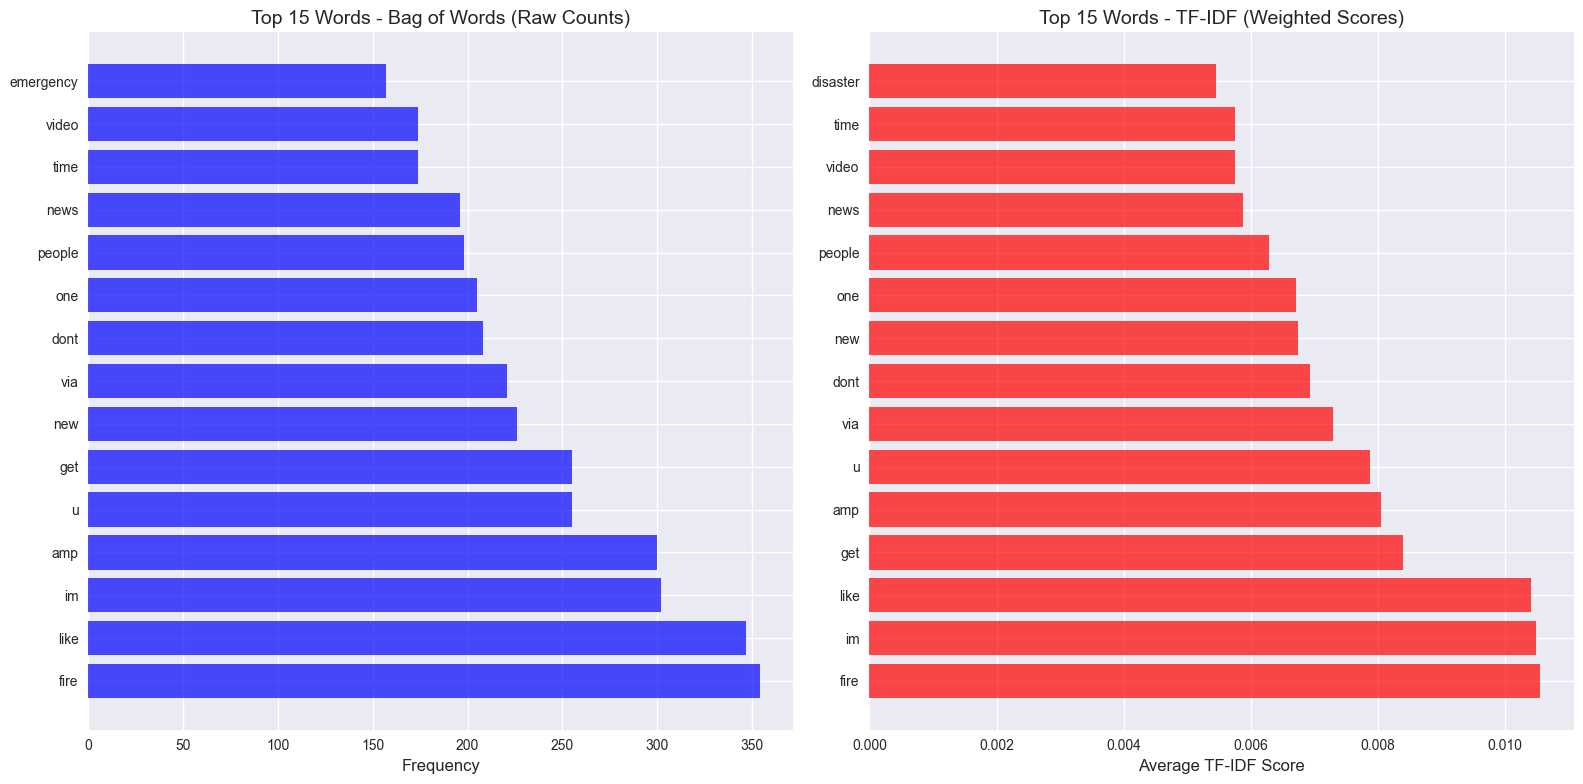

In [40]:
words_in_sample = sample_text.split()
for word in words_in_sample:
    if word in bow_vocabulary:
        bow_idx = np.where(bow_vocabulary == word)[0][0]
        bow_count = bow_doc_vector[bow_idx]
        
        tfidf_idx = np.where(feature_names_full == word)[0][0]
        tfidf_score = tfidf_doc_vector[tfidf_idx]
        
        difference = "Higher" if tfidf_score > bow_count/10 else "Lower"
        print(f"{word:<15} {int(bow_count):<12} {tfidf_score:<12.4f} {difference}")

bow_word_sums = np.array(bow_matrix.sum(axis=0)).flatten()
bow_top_words = [(bow_vocabulary[i], bow_word_sums[i]) for i in bow_word_sums.argsort()[-15:][::-1]]

tfidf_mean_scores = np.array(sklearn_full_tfidf.mean(axis=0)).flatten()
tfidf_top_words = [(feature_names_full[i], tfidf_mean_scores[i]) for i in tfidf_mean_scores.argsort()[-15:][::-1]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

bow_words, bow_counts = zip(*bow_top_words)
ax1.barh(range(len(bow_words)), bow_counts, color='blue', alpha=0.7)
ax1.set_yticks(range(len(bow_words)))
ax1.set_yticklabels(bow_words)
ax1.set_title('Top 15 Words - Bag of Words (Raw Counts)')
ax1.set_xlabel('Frequency')

tfidf_words, tfidf_scores = zip(*tfidf_top_words)
ax2.barh(range(len(tfidf_words)), tfidf_scores, color='red', alpha=0.7)
ax2.set_yticks(range(len(tfidf_words)))
ax2.set_yticklabels(tfidf_words)
ax2.set_title('Top 15 Words - TF-IDF (Weighted Scores)')
ax2.set_xlabel('Average TF-IDF Score')

plt.tight_layout()
plt.show()

In [41]:
bow_top_set = set(word for word, _ in bow_top_words)
tfidf_top_set = set(word for word, _ in tfidf_top_words)
common_words = bow_top_set.intersection(tfidf_top_set)

print(f"\nTOP WORDS COMPARISON:")
print(f"Words in both top 15: {len(common_words)}/15")
print(f"Common words: {sorted(list(common_words))}")
print(f"BoW unique: {sorted(list(bow_top_set - tfidf_top_set))}")
print(f"TF-IDF unique: {sorted(list(tfidf_top_set - bow_top_set))}")

print(f"\nKEY DIFFERENCES:")
print("BAG OF WORDS:")
print("+ Simple frequency counting")
print("+ Easy to interpret")
print("- Dominated by common words")
print("- No consideration of word importance")

print("\nTF-IDF:")
print("+ Balances frequency with rarity")
print("+ Highlights distinctive words")
print("+ Better for document similarity")
print("- More complex to interpret")


TOP WORDS COMPARISON:
Words in both top 15: 14/15
Common words: ['amp', 'dont', 'fire', 'get', 'im', 'like', 'new', 'news', 'one', 'people', 'time', 'u', 'via', 'video']
BoW unique: ['emergency']
TF-IDF unique: ['disaster']

KEY DIFFERENCES:
BAG OF WORDS:
+ Simple frequency counting
+ Easy to interpret
- Dominated by common words
- No consideration of word importance

TF-IDF:
+ Balances frequency with rarity
+ Highlights distinctive words
+ Better for document similarity
- More complex to interpret
